In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline
from matplotlib.colors import LogNorm


import jetson_configs as cfg
from src.ml_helpers.make_ml_dataset import *

# Construct the dataset

In [2]:
split_date     = cfg.train_test_split
current_month  = cfg.current_month

admin_level = "admin1"
horizon     = 1
fpath       = f'{admin_level}_lag{horizon}'

## Get the raw data

In [3]:
learn_df = make_ml_features(current_month, admin_level)

Dropped entirely missing columns:  []
Dropped duplicate columns:  ['miss_vegetation_cover_ndvi']


## Construct a region-level arrivals table

In [4]:
sequences = learn_df['arrivals'].unstack(level='region') #.interpolate()
regions = sequences.columns

# Explore the distribution of arrivals

## Histogram

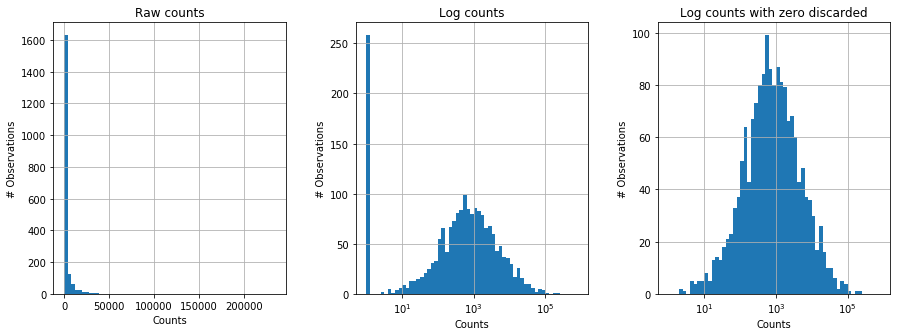

In [5]:
fig,ax = plt.subplots(1,3,figsize=[15,5])
plot_df = learn_df[['arrivals']].fillna(0)
bins = 10**(np.arange(0,6, .1))

plot_df.hist(bins=60, ax=ax[0])
(1+plot_df).hist(bins=bins, ax=ax[1])
plot_df[plot_df>0].arrivals.hist(bins=bins, ax=ax[2])

ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].set_title("Raw counts")
ax[1].set_title("Log counts")
ax[2].set_title("Log counts with zero discarded")

for i in [0,1,2]:
    ax[i].set_xlabel("Counts")
    ax[i].set_ylabel("# Observations")

## Volume

/home/keh494/.conda/envs/py37/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


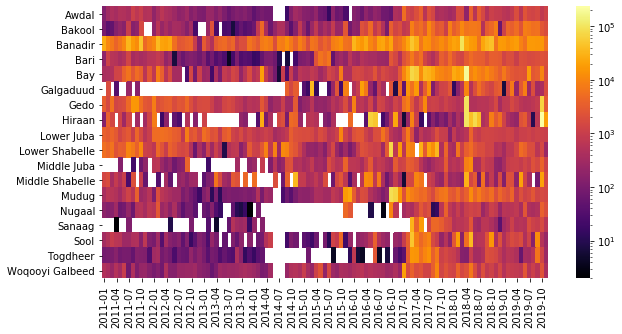

In [6]:
# Prepare plot dataframe
plot_df = learn_df['arrivals'].unstack(level='date')
plot_df.columns =  [str(c)[:7] for c in plot_df.columns]

# Prepare colorbar
min_arrivals, max_arrivals = plot_df.min().min(), plot_df.max().max()
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(min_arrivals)), 
                                             1+math.ceil(math.log10(max_arrivals)))]


fig, ax = plt.subplots(1,1, figsize=[10,5])
sns.heatmap(plot_df, ax=ax, cmap = 'inferno',
            norm=LogNorm(vmin=min_arrivals, vmax=max_arrivals), # Norm the colormap
            cbar_kws={"ticks": cbar_ticks}) # Add the right tix

ax.set_ylabel("")
ax.set_xlabel("")
plt.savefig("figures/arrivals.png", bbox_inches="tight", dpi=100)

## Missing values

region
Lower Juba         0.000000
Banadir            0.000000
Gedo               0.000000
Bay                0.009346
Lower Shabelle     0.009346
Mudug              0.018692
Bari               0.018692
Woqooyi Galbeed    0.028037
Awdal              0.037383
Bakool             0.046729
Sool               0.102804
Middle Shabelle    0.168224
Togdheer           0.205607
Middle Juba        0.205607
Hiraan             0.271028
Nugaal             0.299065
Galgaduud          0.420561
Sanaag             0.570093
dtype: float64

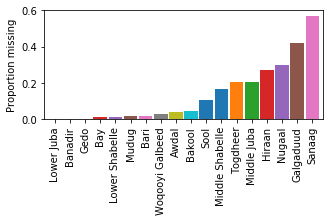

In [7]:
# What percent of regions are missing their dependent variable?
pct_missing_by_region = (1 - (sequences.count() / sequences.count().max())).sort_values()

fig, ax = plt.subplots(1,1,figsize=[5,2])
pct_missing_by_region.plot(kind='bar', width=0.9, ax=ax, ylim=[0,.6])
ax.set_xlabel("")
ax.set_ylabel("Proportion missing")

plt.savefig("figures/pct_missing_target.png", dpi=100, bbox_inches="tight")

pct_missing_by_region

## Average, standard deviation, median

In [8]:
print ("The average number of arrivals is:   ", sequences.unstack().mean())
print("The standard deviation in arrivals is:", sequences.unstack().std())
print("The median number of arrivals is:     ", sequences.unstack().median())
print("\n")

The average number of arrivals is:    3554.6181055155876
The standard deviation in arrivals is: 11277.81326438041
The median number of arrivals is:      729.5




In [9]:
summary_stats = sequences.describe().loc[['mean', 'std', '50%']].T.sort_values('mean')

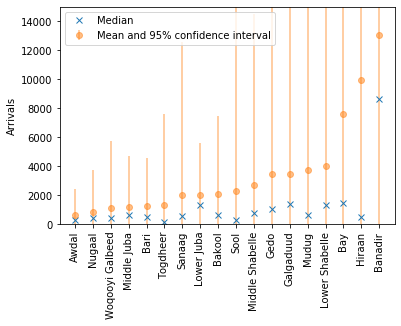

In [10]:
fig,ax=plt.subplots(1,1)

summary_stats['50%'].plot(linestyle='None', marker='x', ax=ax, label='Median', rot=90)
ax.errorbar(x=summary_stats.index, y=summary_stats['mean'], yerr = 2*summary_stats['std'], alpha=0.5, linestyle='None', marker="o", 
            label = 'Mean and 95% confidence interval')
ax.legend(loc='upper left')
ax.set_xlabel("")
ax.set_ylabel("Arrivals")
ax.set_ylim(0,15000)

ax.set_xticklabels(summary_stats.index)

plt.savefig("figures/avg_median_arrivals.png", dpi=100, bbox_inches="tight")

In [11]:
summary_stats

,mean,std,50%
region,,,
Awdal,638.048544,885.011027,302.0
Nugaal,843.840000,1454.093635,412.0
Woqooyi Galbeed,1091.288462,2314.007681,426.0
Middle Juba,1155.505882,1779.144435,626.0
Bari,1275.561905,1633.714414,485.0
Togdheer,1284.305882,3143.606145,127.0
Sanaag,1973.804348,5287.795725,547.0
Lower Juba,1984.626168,1809.042145,1284.0
Bakool,2044.186275,2703.806139,606.5


# Assess autocorrelation

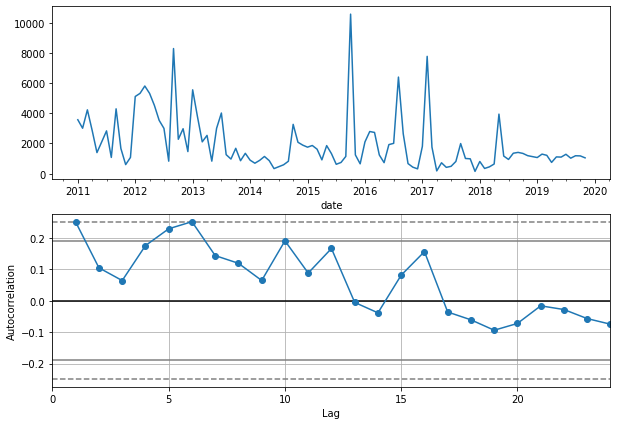

In [12]:
fig, ax = plt.subplots(2,1,figsize=[10,7])

# Option 1: Select a single region
regions=['Lower Juba']

# Option 2: Select regions with few missing values
#regions = pct_missing_by_region[pct_missing_by_region<0.1].index

for r in regions:
    sequences[r].plot(ax=ax[0])
    autocorrelation_plot(sequences[r].ffill(), ax=ax[1], marker="o")

    ax[1].set_xlim(0,24)

1     21.0
2     14.0
3     11.0
4      9.0
5      8.0
6     10.0
7     12.0
8      8.0
9      6.0
10     4.0
11     8.0
12    11.0
13     9.0
14     9.0
15     4.0
16     8.0
17     5.0
18    12.0
19     7.0
20     5.0
21     3.0
22     2.0
23     7.0
dtype: float64

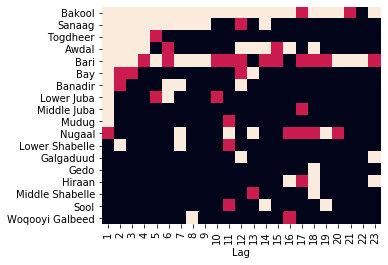

In [13]:
# Build a dataframe with the autocorrelations
autocorr_df = pd.DataFrame(columns = sequences.columns)

for r in sequences.columns:
    for lag in range(1,24):
        autocorr_df.loc[lag, r] = sequences[r].autocorr(lag)

# Flag significant autocorrelations
sig95 = 1.959963984540054 / np.sqrt(sequences.shape[0])
sig99 = 2.5758293035489004 / np.sqrt(sequences.shape[0])

sig_autocorr_df = (autocorr_df > sig95).astype(float) + (autocorr_df > sig99).astype(float)

# Plot
fig,ax=plt.subplots(1,1,figsize=[5,4])
sig_autocorr_df = sig_autocorr_df.T.sort_values([1,2,3,4,5,6], ascending=False)
sns.heatmap(sig_autocorr_df, ax=ax, cbar=False)
ax.set_ylabel("")
ax.set_xlabel("Lag")
plt.savefig("figures/autocorrelation.png", dpi=100, bbox_inches="tight")

sig_autocorr_df.sum()

In [14]:
print ("On average, the change in arrivals is:", (sequences - sequences.shift(1)).unstack().mean())
print("The median change in arrivals is:    ", (sequences - sequences.shift(1)).unstack().median())
print("The standard deviation in arrivals is:    ", (sequences - sequences.shift(1)).unstack().std())
print("\n")
print("The median of the absolute value of the change in arrivals is:", (np.abs(sequences - sequences.shift(1))).unstack().median())
print ("On average, the absolute value of the change in arrivals is: ", (np.abs(sequences - sequences.shift(1))).unstack().mean())

On average, the change in arrivals is: 1.5987179487179488
The median change in arrivals is:     -14.0
The standard deviation in arrivals is:     13865.024887166388


The median of the absolute value of the change in arrivals is: 518.5
On average, the absolute value of the change in arrivals is:  3594.201282051282
